In [3]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd


sys.path.append('../../')  # Add the path to the my_packages module
os.environ['EXPERIMENT_DB_NAME'] = "context_experiments"
from my_packages.analysis.error_analysis import categorize_semantic_errors, categorize_syntax_error, categorize_syntax_parsing_error, categorize_test_errors, extract_semantic_errors, extract_test_error, get_error_category_counts, make_categories_bar_chart, make_categories_pie_chart
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection

experiment_name = f"RAG_5_shot"
prompt_types = ["regular", "signature"]
models = ["phi4:14b-fp16", "llama3.2:3b-instruct-fp16", "llama3.3:70b-instruct-fp16"]


# Categorize and extract errors:

for prompt in prompt_types:
    print(f"\n\n{prompt.upper()} prompts:\n")
    for model in models:
        print(f"\n    {model.upper()} model:\n")    
        filter = {
            "eval_method": "3_fold",
            "model_name": model,
            "phase": "testing", 
        }
        df = errors_to_df(f"{prompt}_{experiment_name}", filter=filter)
        # print(df.count())
        df["syntax_error"] = df["stderr"]
        df["syntax_parsing_error"] = df["stderr"].apply(categorize_syntax_parsing_error)
        df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)

        df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
        df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)

        df["tests_category"] = df["test_result"].apply(categorize_test_errors)
        df["tests_error"] = df.apply(
            lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
            axis=1
        )
        error_type = ["syntax", "semantic"] if prompt == "regular" else ["syntax", "semantic", "tests"]

        for error_type in error_type:
            filtered_df = df[
                (df["error_type"] == error_type) 
                # & (df[f"{error_type}_category"] == {'Symbol Resolution Error'})
                # & (df[f"syntax_parsing_error"] == '[Parsing failed]') 

            ]

            errors_count_df = get_error_category_counts(filtered_df, f"{error_type}_category")
            print(errors_count_df)

            # # Show all rows
            # pd.set_option('display.max_rows', None)     

            # # Show all columns
            # pd.set_option('display.max_columns', None)

            # # Show full content in each cell
            # pd.set_option('display.max_colwidth', None)

            # print(df["error_type"].unique())

# make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
# make_categories_bar_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")


# filtered_df.head(50)





REGULAR prompts:


    PHI4:14B-FP16 model:

         category  count  percentage
0  Parsing failed    804       100.0
                  category  count  percentage
0  Symbol Resolution Error   2281   47.789650
1    Type Resolution Error   1918   40.184370
2       Invalid connection    370    7.751938
3     Other Semantic Error    102    2.137021
4         Duplicate symbol     86    1.801802
5  Invalid function header     16    0.335219

    LLAMA3.2:3B-INSTRUCT-FP16 model:

              category  count  percentage
0       Parsing failed    954   98.452012
1  Tokenization failed     15    1.547988
                     category  count  percentage
0     Symbol Resolution Error    955   47.917712
1       Type Resolution Error    850   42.649272
2          Invalid connection     94    4.716508
3     Invalid function header     34    1.705971
4            Duplicate symbol     28    1.404917
5        Other Semantic Error     14    0.702459
6       Invalid AST structure     10    0.501756


# Syntax error comparrison

## Copy error collection to another db

In [11]:
import os
import subprocess
import sys
sys.path.append('../../')  # Add the path to the my_packages module

from my_packages.db_service import get_db_connection

from_experiment = "few_shot"
to_experiment = "context"
source_db = get_db_connection(f"{from_experiment}_experiments")
target_db = get_db_connection(f"{to_experiment}_experiments")

for prompt in ["regular", "signature"]:
    source_collection = source_db[f"{prompt}_similarity_5_shot_errors"]

    new_target_collection_name = f"{prompt}_{from_experiment}_5_shot_errors"
    if new_target_collection_name in target_db.list_collection_names():
        print(f"Collection {new_target_collection_name} already exists in {target_db.name} DB. Skipping.")
        continue
    target_collection = target_db[new_target_collection_name]

    docs = list(source_collection.find())  # Use list() to avoid cursor exhaustion
    if docs:
        target_collection.insert_many(docs)
        print(f"Copied {len(docs)} docs to  {new_target_collection_name} in {target_db.name} DB.")
    else:
        print(f"No documents found in {new_target_collection_name} in {target_db.name} DB.")


Collection regular_few_shot_5_shot_errors already exists in context_experiments DB. Skipping.
Collection signature_few_shot_5_shot_errors already exists in context_experiments DB. Skipping.


# Compariison DF and tables

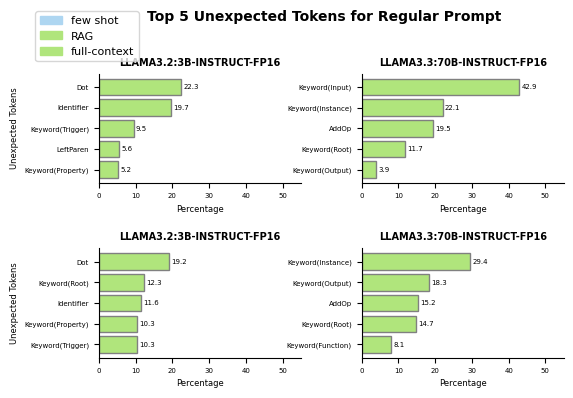

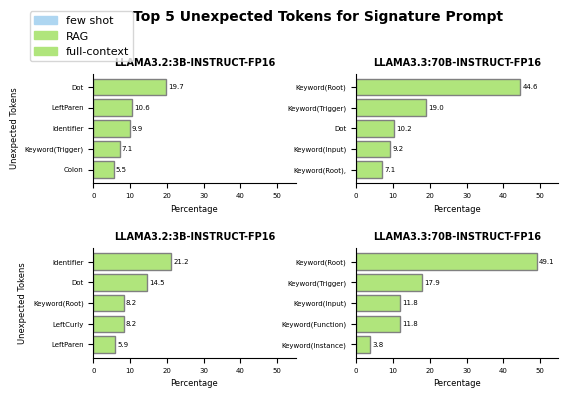

In [43]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


experiment = "context_experiments"

experiment_types = ["RAG", "full-context"]
color_map = {
    "few_shot": "#aed6f1",
    "RAG": "#b0e57c",
    "full-context": "#b0e57c",
}
#aed6f1
models = ["llama3.2:3b-instruct-fp16", "phi4:14b-fp16", "llama3.3:70b-instruct-fp16"]
prompts = ["regular", "signature"]
shot = 5

os.environ['EXPERIMENT_DB_NAME'] = experiment

sys.path.append('../../')  # Add the path to the my_packages module
from my_packages.analysis.error_analysis import (
    categorize_semantic_errors, 
    categorize_syntax_error, 
    categorize_syntax_parsing_error,
    categorize_test_errors, 
    extract_semantic_errors, 
    extract_test_error, 
    get_error_category_counts, 
    make_categories_bar_chart, 
    make_categories_pie_chart
)
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection

def categorize_erors(experiment_name: str,
                     metric: str,
                     filter: dict
                    ):
    # Categorize and extract errors
    df = errors_to_df(experiment_name, filter=filter)
    if metric == "syntax":
        df["syntax_error"] = df["stderr"]
        df["syntax_parsing_error"] = df["stderr"].apply(categorize_syntax_parsing_error)
        df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)
    elif metric == "semantic":
        df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
        df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)
    elif metric == "tests":
        df["tests_category"] = df["test_result"].apply(categorize_test_errors)
        df["tests_error"] = df.apply(
            lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
            axis=1
        )
    return df

def get_all_errors_comparison(metric, models, experiment_types, prompt, shot, parsing_errors = True):
    rows = []
    for model in models:
        for experiment_type in experiment_types:
            df = categorize_erors(
                experiment_name=f"{prompt}_{experiment_type}_{shot}_shot",
                metric=metric,
                filter={"eval_method": "3_fold", "model_name": model, "phase": "testing"},
            )
            filtered_df = df[df["error_type"] == metric]
            if parsing_errors:
                filtered_df = filtered_df[filtered_df["syntax_category"] == "Parsing failed"]
                errors_count_df = get_error_category_counts(filtered_df, f"{metric}_parsing_error")
            else:
                errors_count_df = get_error_category_counts(filtered_df, f"{metric}_category")
        
            # Loop over each error category row and append as individual rows
            # make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
            # make_categories_bar_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
            for _, row in errors_count_df.iterrows():
                rows.append({
                    "model": model,
                    "prompt": prompt,
                    "experiment_type": experiment_type,
                    "shots": shot,
                    "category": row["category"],
                    "count": row["count"],
                    "percentage": row["percentage"],
                })
    return pd.DataFrame(rows)

if  "full-context" in experiment_types and "phi4:14b-fp16" in models:
    models.remove("phi4:14b-fp16")

for prompt in prompts:
    comparison_df = get_all_errors_comparison("syntax", models, experiment_types, prompt, shot, parsing_errors=True)

    rows = len(prompts)
    cols = len(models)
    fig, axs = plt.subplots(rows, cols, figsize=((cols*3), (rows*2)))  # Slightly shorter height

    for row_idx, experiment_type in enumerate(experiment_types):
        for col_idx, model in enumerate(models):
            ax = axs[row_idx, col_idx]
            df = comparison_df[
                (comparison_df["experiment_type"] == experiment_type) & (comparison_df["model"] == model)
            ]

            df = df.sort_values(by="percentage", ascending=False).head(5)
            df = df.sort_values(by="percentage", ascending=True)

            bars = ax.barh(
                df["category"], 
                df["percentage"], 
                color=color_map[experiment_type], 
                edgecolor="gray"
            )

            for bar in bars:
                width = bar.get_width()
                ax.text(width + 0.6, bar.get_y() + bar.get_height() / 2,
                        f"{width:.1f}", va="center", fontsize=5)

            # Enhance title
            model_label = model.upper()
            ax.set_title(model_label, fontsize=7, fontweight='bold')
            ax.set_xlim(0, 55)
            ax.set_xlabel("Percentage", fontsize=6)
            ax.set_ylabel(f"Unexpected Tokens", fontsize=6) if col_idx == 0 else ax.set_ylabel("")
            ax.tick_params(axis='both', labelsize=5)
            ax.spines[['top', 'right']].set_visible(False)

    # Adjust spacing between subplots
    fig.suptitle(f"Top 5 Unexpected Tokens for {prompt.capitalize()} Prompt\n", fontsize=10, fontweight='bold')
    legend_handles = [
        mpatches.Patch(color=color, label=label.replace("_", " "))
        for label, color in color_map.items()
    ]

    fig.legend(
        handles=legend_handles,
        title="",
        loc='upper left',
        bbox_to_anchor=(0.01, 0.99),  # Fine-tune as needed
        fontsize=8,
        title_fontsize=8,
        # prop={'weight': 'semibold'},         # Make label text bold
     
    )

    plt.subplots_adjust(wspace=0.3, hspace=0.6, top=0.82)

    # plt.tight_layout(pad=0.1)
    plt.savefig(f"{prompt}_{experiment}_top5_unexpected_tokens_all_models_compact.png", dpi=300)
    plt.show()
